## Nassau County Housing Cost Predictions - Classification Models
This project aims to analyze Nassau County housing costs using Zillow data (scraped by Apify). The dataset has been initially cleaned, as null values have been handled. All initial null values (except tax assessed values for each home) have been handled accordingly in initial_cleaning.py. All data was provided by Apify's Zillow scraper.

### 1. Set Up

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
connection = sqlite3.connect('zillow_data.db')
df = pd.read_sql_query("SELECT * FROM listings", connection)
df.head()

,id,address,addressCity,addressState,addressZipcode,bedrooms,bathrooms,area,daysOnZillow,price,lotAreaValue,lotAreaUnit,taxAssessedValue,homeStatus,latitude,longitude
0,2,"4 Aron Drive, Woodbury, NY 11797",Woodbury,NY,11797,5,5.0,4000.0,12,2699999,0.460009,acres,912000.0,FOR_SALE,40.825302,-73.476944
1,3,"2607 Falcon Street, East Meadow, NY 11554",East Meadow,NY,11554,4,2.0,1260.0,6,750000,7200.000000,sqft,519000.0,FOR_SALE,40.711006,-73.538830
2,5,"17 Pinetree Drive, Farmingdale, NY 11735",Farmingdale,NY,11735,3,3.0,1540.0,4,629000,7140.000000,sqft,441000.0,FOR_SALE,40.719440,-73.466995
3,6,"35 Bayview Avenue, Port Washington, NY 11050",Port Washington,NY,11050,4,2.0,2164.0,5,1225000,5650.000000,sqft,705000.0,FOR_SALE,40.826836,-73.697530
4,7,"138 Mount Joy Avenue, Freeport, NY 11520",Freeport,NY,11520,3,4.0,1638.0,13,588786,6250.000000,sqft,406000.0,FOR_SALE,40.670380,-73.593330


In [3]:
df.shape

(1565, 16)

### 2. EDA and Feature Engineering
- Ordinal Encoding
- OLS Regression Model (to handle null tax assessment values)
- Label Binning using Quartiles

In [4]:
for col in df.columns:
    print(f"{col}: {sum(df[col].isna())}")

id: 0
address: 0
addressCity: 0
addressState: 0
addressZipcode: 0
bedrooms: 0
bathrooms: 0
area: 0
daysOnZillow: 0
price: 0
lotAreaValue: 0
lotAreaUnit: 0
taxAssessedValue: 138
homeStatus: 0
latitude: 0
longitude: 0


In [5]:
for col in df[["addressCity","lotAreaUnit", "homeStatus", "addressState"]].columns:
    print(f"{col}: {df[col].unique()}")

addressCity: ['Woodbury' 'East Meadow' 'Farmingdale' 'Port Washington' 'Freeport'
 'Hempstead' 'Valley Stream' 'West Hempstead' 'Mineola' 'Oceanside'
 'Merrick' 'Glen Cove' 'Massapequa' 'Lynbrook' 'Elmont' 'Franklin Square'
 'Uniondale' 'Oyster Bay' 'Hewlett' 'New Hyde Park' 'Seaford' 'Great Neck'
 'Old Bethpage' 'Roosevelt' 'East Rockaway' 'Roslyn Heights' 'Lido Beach'
 'Carle Place' 'Floral Park' 'Garden City' 'Baldwin' 'Massapequa Park'
 'Hicksville' 'Wantagh' 'Levittown' 'Bellmore' 'Oyster Bay Cove' 'Syosset'
 'Plainview' 'Locust Valley' 'Westbury' 'Bethpage' 'East Norwich'
 'Old Westbury' 'Jericho' 'Bayville' 'Brookville' 'Roslyn' 'Manhasset'
 'Sea Cliff' 'Glenwood Landing' 'Albertson' 'Williston Park'
 'South Floral Park' 'Long Beach' 'Island Park' 'North Bellmore'
 'Malverne' 'Inwood' 'Lawrence' 'Woodsburgh' 'Atlantic Beach' 'Cedarhurst'
 'Woodmere' 'East Atlantic Beach' 'North Merrick' 'Mill Neck' 'Glen Head'
 'Centre Island' 'Muttontown' 'Cold Spring Harbor' 'Old Brookville'
 

We will use ordinal encoding for the various cities found in the County, and for the lot area units.

In [6]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
df[["addressCity","lotAreaUnit"]] = encoder.fit_transform(df[["addressCity", "lotAreaUnit"]])

In [7]:
for col in df[["addressCity","lotAreaUnit"]].columns:
    print(f"{col}: {df[col].unique()}")

addressCity: [77. 14. 19. 59. 22. 29. 72. 74. 47. 52. 45. 24. 43. 40. 18. 21. 71. 56.
 30. 49. 68. 27. 53. 62. 16. 64. 37.  9. 20. 23.  2. 44. 31. 73. 36.  5.
 57. 70. 58. 38. 75.  6. 15. 55. 34.  4.  7. 63. 42. 67. 26.  0. 76. 69.
 39. 33. 50. 41. 32. 35. 79.  1. 10. 78. 13. 51. 46. 25. 11. 48. 12. 54.
 65. 28. 60. 17. 66.  3. 61.  8.]
lotAreaUnit: [0. 1.]


We will drop the ID, status, and the state; they don't provide any predictive power.

In [8]:
df = df.drop(['id', 'homeStatus', 'addressState'], axis=1)
df.head()

,address,addressCity,addressZipcode,bedrooms,bathrooms,area,daysOnZillow,price,lotAreaValue,lotAreaUnit,taxAssessedValue,latitude,longitude
0,"4 Aron Drive, Woodbury, NY 11797",77.0,11797,5,5.0,4000.0,12,2699999,0.460009,0.0,912000.0,40.825302,-73.476944
1,"2607 Falcon Street, East Meadow, NY 11554",14.0,11554,4,2.0,1260.0,6,750000,7200.000000,1.0,519000.0,40.711006,-73.538830
2,"17 Pinetree Drive, Farmingdale, NY 11735",19.0,11735,3,3.0,1540.0,4,629000,7140.000000,1.0,441000.0,40.719440,-73.466995
3,"35 Bayview Avenue, Port Washington, NY 11050",59.0,11050,4,2.0,2164.0,5,1225000,5650.000000,1.0,705000.0,40.826836,-73.697530
4,"138 Mount Joy Avenue, Freeport, NY 11520",22.0,11520,3,4.0,1638.0,13,588786,6250.000000,1.0,406000.0,40.670380,-73.593330


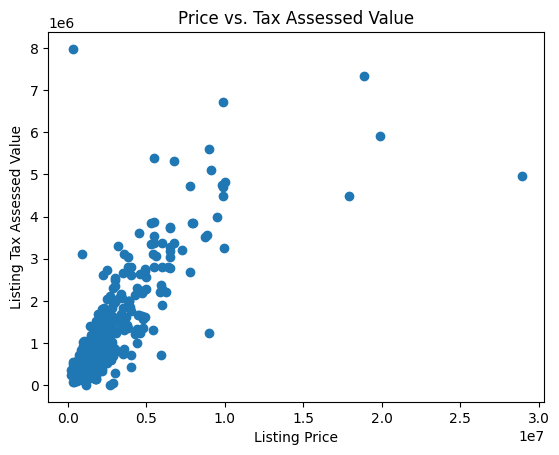

In [9]:
plt.scatter(data=df, x="price", y="taxAssessedValue")
plt.xlabel("Listing Price")
plt.ylabel("Listing Tax Assessed Value")
plt.title("Price vs. Tax Assessed Value")
plt.show()

We will create an OLS regression model for the tax assessed value and the listing price. This regression function will then be used to fill in the null values for tax assessment.

In [10]:
import statsmodels.api as sm # type: ignore

df_non_null = df.dropna(subset=['price', 'taxAssessedValue'])
# transform X into a constant for OLS regression model
ols_X = sm.add_constant(df_non_null['price'])
tax_formula = sm.OLS(df_non_null['taxAssessedValue'], ols_X).fit()
print(tax_formula.summary())

intercept, slope = tax_formula.params
print(f"Regression equation: Y = {intercept:.2f} + {slope:.2f} * X")

                            OLS Regression Results                            
Dep. Variable:       taxAssessedValue   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     2992.
Date:                Fri, 18 Apr 2025   Prob (F-statistic):               0.00
Time:                        15:56:59   Log-Likelihood:                -20519.
No. Observations:                1427   AIC:                         4.104e+04
Df Residuals:                    1425   BIC:                         4.105e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.469e+05   1.48e+04     16.636      0.0

In [11]:
df_missing = df[df['taxAssessedValue'].isnull()]
X_missing = sm.add_constant(df_missing['price'])
predicted_values = tax_formula.predict(X_missing)
df.loc[df['taxAssessedValue'].isnull(), 'taxAssessedValue'] = predicted_values

print(sum(df['taxAssessedValue'].isna()))

0


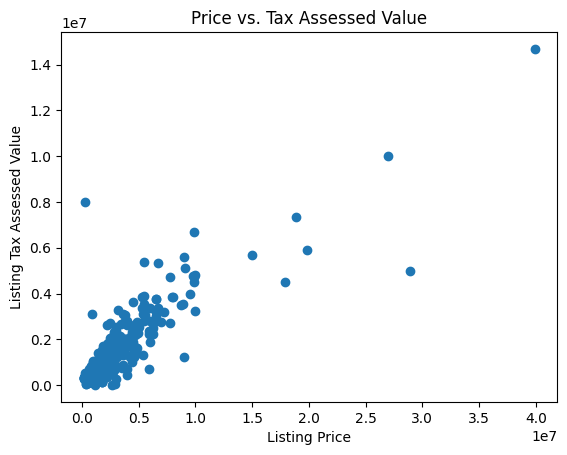

In [12]:
plt.scatter(data=df, x="price", y="taxAssessedValue")
plt.xlabel("Listing Price")
plt.ylabel("Listing Tax Assessed Value")
plt.title("Price vs. Tax Assessed Value")
plt.show()

In [13]:
# saving all the preprocessing to a new table
df.to_sql('preprocessed listings', connection, if_exists='replace')
connection.commit()
connection.close()

In [14]:
df['price'].describe()

count    1.565000e+03
mean     1.518790e+06
std      2.063196e+06
min      1.749900e+05
25%      7.490000e+05
50%      9.488880e+05
75%      1.588000e+06
max      3.990000e+07
Name: price, dtype: float64

In [15]:
q1 = df['price'].quantile(0.25)
q2 = df['price'].quantile(0.50)
q3 = df['price'].quantile(0.75)
print(f"Q1: {q1}, Q2 (median): {q2}, Q3: {q3} ")

bins = [df['price'].min(), q1, q2, q3, df['price'].max()]
labels = ['min-Q1', 'Q1-Q2', 'Q2-Q3', 'Q3-max']

df['price_bins'] = pd.cut(df['price'], bins=bins, labels=labels, include_lowest=True)
print(df[['price', 'price_bins']])

Q1: 749000.0, Q2 (median): 948888.0, Q3: 1588000.0 
        price price_bins
0     2699999     Q3-max
1      750000      Q1-Q2
2      629000     min-Q1
3     1225000      Q2-Q3
4      588786     min-Q1
...       ...        ...
1560  1720000     Q3-max
1561  1199888      Q2-Q3
1562   969999      Q2-Q3
1563   680000     min-Q1
1564  1699000     Q3-max

[1565 rows x 2 columns]


In [16]:
features = df.drop(['price', 'price_bins', 'address'], axis=1)
label = df['price_bins']

print(f'Shape of features: {features.shape}')
print(f'Shape of label: {label.shape}')

Shape of features: (1565, 11)
Shape of label: (1565,)


### 3. Model Development (With `taxAssessedValue`)
- Logistic Regression
- Decision Tree
- Random Forest
- KNN
- Fine tuned all models using Grid Search

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# standardization of the features to scale them in the modeling properly
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, label, test_size=0.2, random_state=42)

In [18]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=2000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier()
}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)  # calculate accuracy for base models
    print(f'{model_name} Accuracy: {accuracy:.2f}')

Logistic Regression Accuracy: 0.62
Decision Tree Accuracy: 0.63
Random Forest Accuracy: 0.69
KNN Accuracy: 0.57


In [19]:
from sklearn.model_selection import GridSearchCV

# parameter grids for each model
param_grid = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 50, 100],  # regularization strength
        'solver': ['liblinear', 'saga']  # solvers to explore
    },
    'Decision Tree': {
        'max_depth': [1, 5, 10, 15, 20, 25, 30],  # max depth of the tree
        'min_samples_split': [2, 5, 10, 15, 25]  # min samples required to split an internal node
    },
    'Random Forest': {
        'n_estimators': [10, 50, 100, 150, 200, 250],  # num trees in the forest
        'max_depth': [2, 5, 10, 20, 30],  # max depth of the tree
        'min_samples_split': [2, 5, 10, 15, 25]  # min samples required to split an internal node
    },
    'KNN': {
        'n_neighbors': range(1, 21),  # k values from 1 to 20
        'weights': ['uniform', 'distance']  # weight functions to explore
    }
}

Tuning Logistic Regression...
Best Parameters for Logistic Regression: {'C': 10, 'solver': 'saga'}
Best Cross-Validation Accuracy for Logistic Regression: 0.68


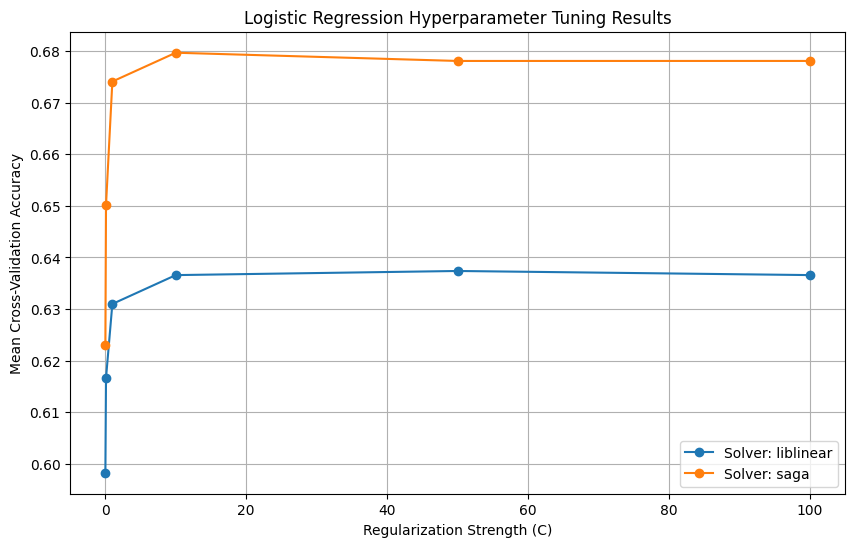

Tuning Decision Tree...
Best Parameters for Decision Tree: {'max_depth': 5, 'min_samples_split': 2}
Best Cross-Validation Accuracy for Decision Tree: 0.66


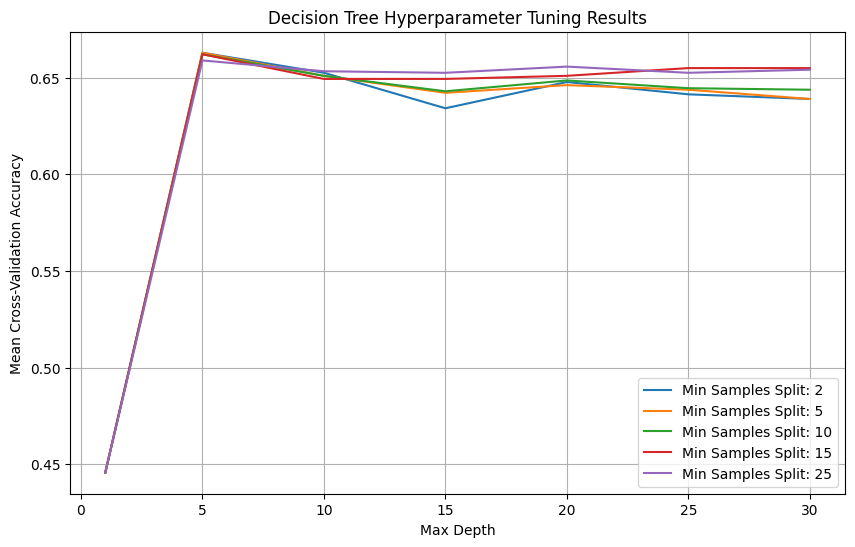

Tuning Random Forest...
Best Parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 15, 'n_estimators': 50}
Best Cross-Validation Accuracy for Random Forest: 0.75


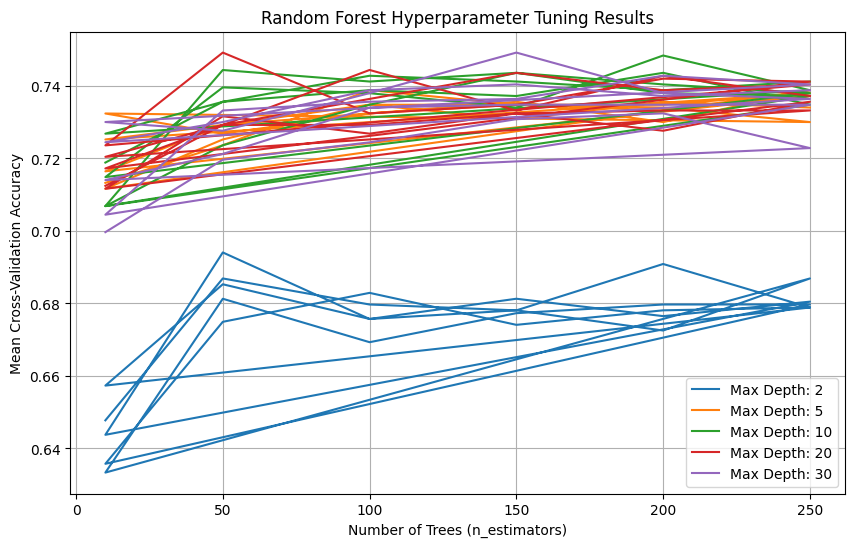

Tuning KNN...
Best Parameters for KNN: {'n_neighbors': 13, 'weights': 'distance'}
Best Cross-Validation Accuracy for KNN: 0.64


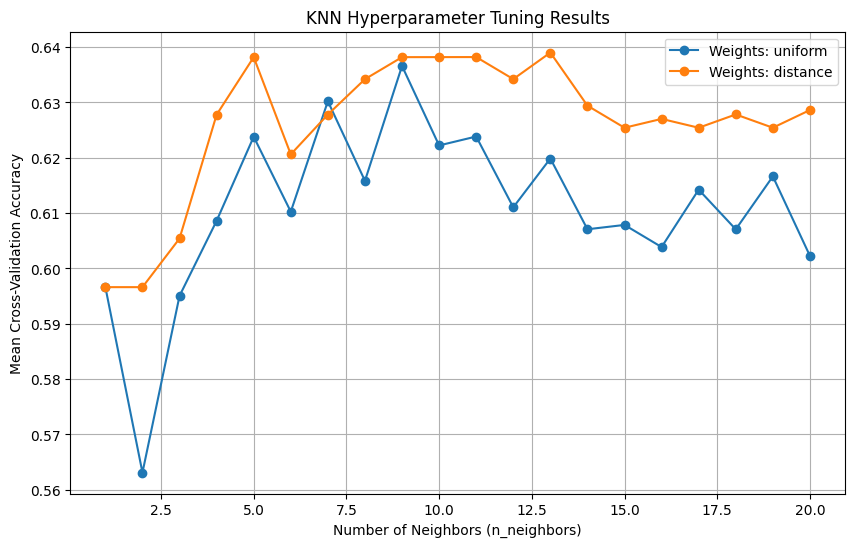

In [20]:
# iterate through the models and perform Grid Search
for model_name, model in models.items():
    print(f'Tuning {model_name}...')
    grid_search = GridSearchCV(model, param_grid[model_name], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    print(f'Best Parameters for {model_name}: {best_params}')
    print(f'Best Cross-Validation Accuracy for {model_name}: {best_score:.2f}')
    
    results = pd.DataFrame(grid_search.cv_results_)
    
    plt.figure(figsize=(10, 6))
    
    # Logistic Regression, can plot against C and solver
    if model_name == 'Logistic Regression':
        for solver in param_grid[model_name]['solver']:
            subset = results[results['param_solver'] == solver]
            plt.plot(subset['param_C'], subset['mean_test_score'], marker='o', label=f'Solver: {solver}')
        plt.xlabel('Regularization Strength (C)')
            
    # Decision Tree, plot against max_depth and min_samples_split
    elif model_name == 'Decision Tree':
        for min_samples in param_grid[model_name]['min_samples_split']:
            subset = results[results['param_min_samples_split'] == min_samples]
            plt.plot(subset['param_max_depth'], subset['mean_test_score'], label=f'Min Samples Split: {min_samples}')
        plt.xlabel('Max Depth')
    
    #  Random Forest, plot against n_estimators and max_depth
    elif model_name == 'Random Forest':
        for depth in param_grid[model_name]['max_depth']:
            subset = results[results['param_max_depth'] == depth]
            plt.plot(subset['param_n_estimators'], subset['mean_test_score'], label=f'Max Depth: {depth}')
        plt.xlabel('Number of Trees (n_estimators)')
    
    # KNN, can plot against weight type and n_neighbors
    elif model_name == 'KNN':
        for weight in param_grid[model_name]['weights']:
            subset = results[results['param_weights'] == weight]
            plt.plot(subset['param_n_neighbors'], subset['mean_test_score'], marker='o', label=f'Weights: {weight}')
        plt.xlabel('Number of Neighbors (n_neighbors)')

    
    plt.title(f'{model_name} Hyperparameter Tuning Results')
    plt.ylabel('Mean Cross-Validation Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

### 4. Feature Analysis (With `taxedAssessedValue`)
- Correlation Matrix
- Feature Importances/Coefficients

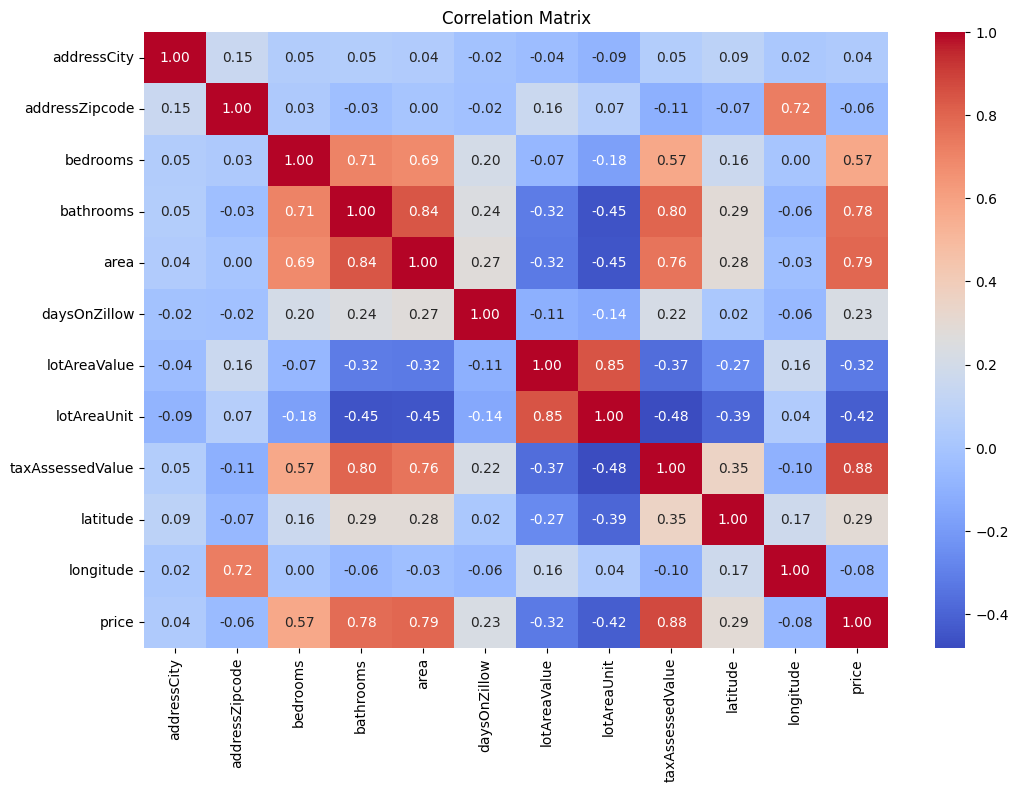

In [21]:
import seaborn as sns

# combine features and label into a single DataFrame
data = features.copy()
data['price'] = df['price']

correlation_matrix = data.corr()

plt.figure(figsize=(12, 8))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

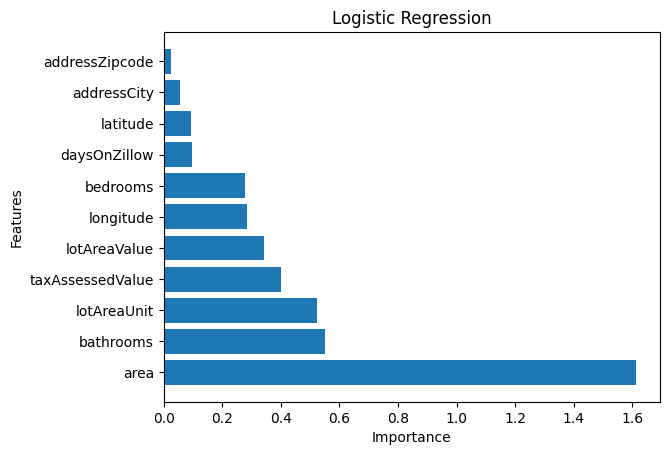

Top 3 Features for Logistic Regression: Index(['area', 'bathrooms', 'lotAreaUnit'], dtype='object')


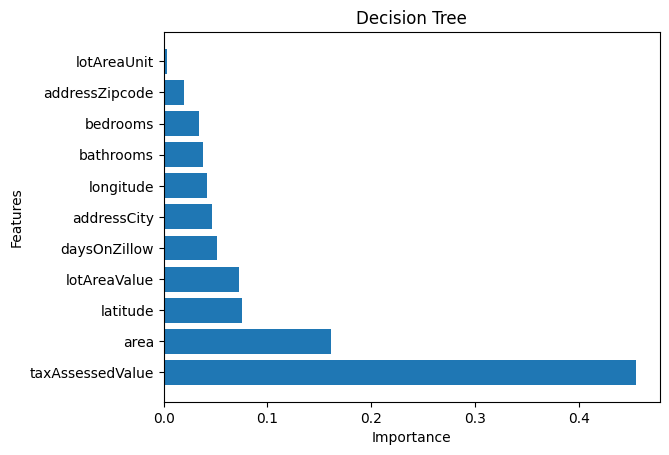

Top 3 Features for Decision Tree: Index(['taxAssessedValue', 'area', 'latitude'], dtype='object')


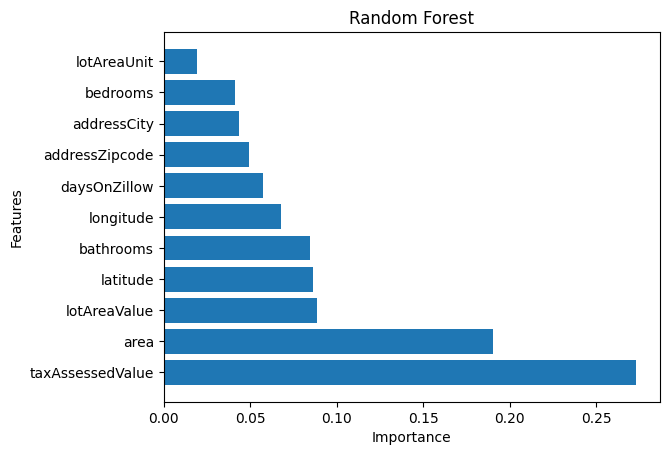

Top 3 Features for Random Forest: Index(['taxAssessedValue', 'area', 'lotAreaValue'], dtype='object')

KNN does not provide feature importances.


In [22]:
import numpy as np

for model_name, model in models.items():
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])  # for Logistic Regression
    else:
        importances = None  # KNN does not have feature importances

    if importances is not None:
        # sort importances and get top 3 features
        sorted_indices = np.argsort(importances)[::-1]
        sorted_importances = importances[sorted_indices]
        top_feature_names = features.columns[sorted_indices]
        
        # Plotting
        plt.barh(top_feature_names, sorted_importances, align='center')
        plt.title(model_name)
        plt.xlabel('Importance')
        plt.ylabel('Features')
        plt.show()
        
        print(f"Top 3 Features for {model_name}: {top_feature_names[:3]}")
    else:
        print(f"\n{model_name} does not provide feature importances.")

### 5. Current Thoughts
- Important Observations:
    - From the correlation matrix, `price` has strong positive correlations with:
        - `taxAssessedValue` (0.88)
        - `area` (0.79)
        - `bathrooms` (0.78)
        - `bedrooms` (0.57)
        - However, there is also indication of multi-collinearity between the features; linear regression will probably not be adequate for modelling this problem then
            - e.g. `bedrooms` and `bathrooms` : (0.71)
- *** `taxAssessedValue` could cause data leakage, we can evaluate the models without this feature and then compare results

### 6. Model Development (Without `taxAssessmentValue`)
- We will be using the same models from the first stage of model development, and the methods to fine-tune them
- We will compare the model performance without `taxAssessedValue`, as its inclusion could lead to data leakage
- Why exclude it?
    - Data leakage occurs when a model has access to information during training that it wouldn't have in a real-world scenario
    - In this problem, `taxAssessedValue` may reflect knowledge of the home's sale price

In [23]:
features = df.drop(['price', 'price_bins', 'address', 'taxAssessedValue'], axis=1)
X_scaled = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, label, test_size=0.2, random_state=42)

In [24]:
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)  # calculate accuracy for base models
    print(f'{model_name} Accuracy: {accuracy:.2f}')

Logistic Regression Accuracy: 0.59
Decision Tree Accuracy: 0.59
Random Forest Accuracy: 0.65
KNN Accuracy: 0.57


Tuning Logistic Regression...
Best Parameters for Logistic Regression: {'C': 1, 'solver': 'saga'}
Best Cross-Validation Accuracy for Logistic Regression: 0.65


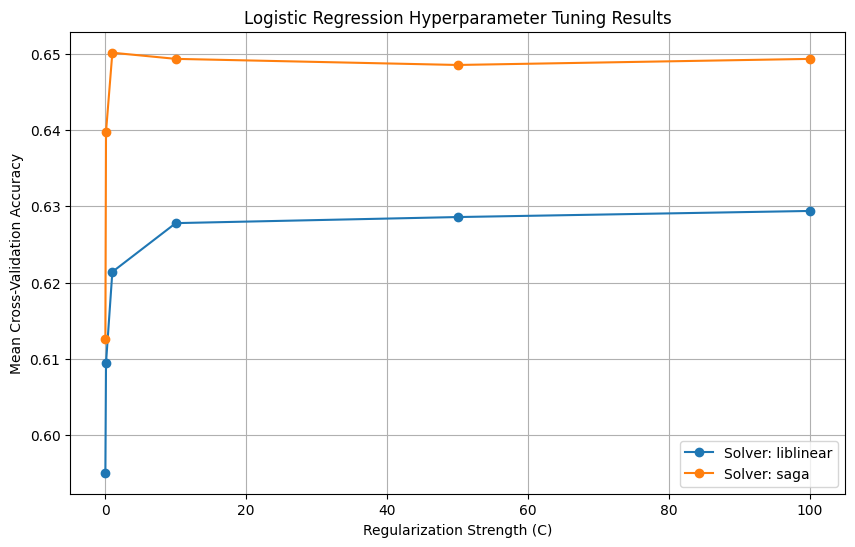

Tuning Decision Tree...
Best Parameters for Decision Tree: {'max_depth': 15, 'min_samples_split': 25}
Best Cross-Validation Accuracy for Decision Tree: 0.62


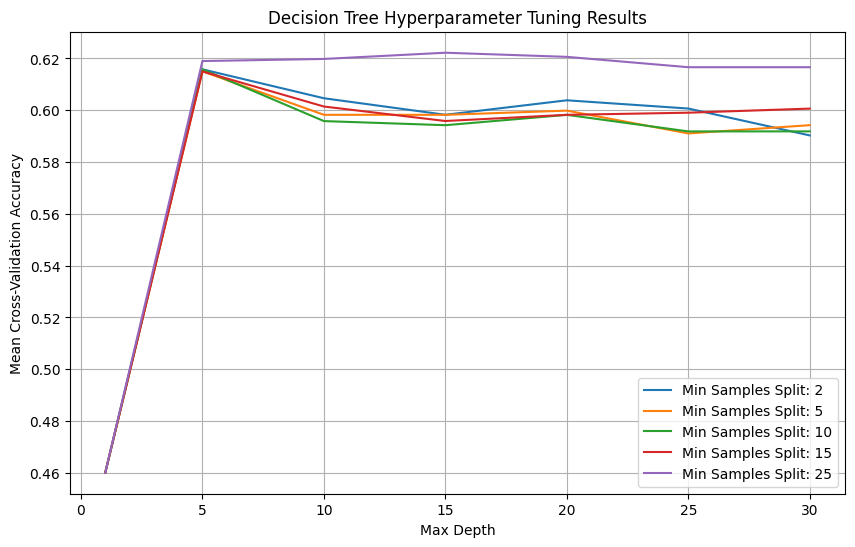

Tuning Random Forest...
Best Parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}
Best Cross-Validation Accuracy for Random Forest: 0.72


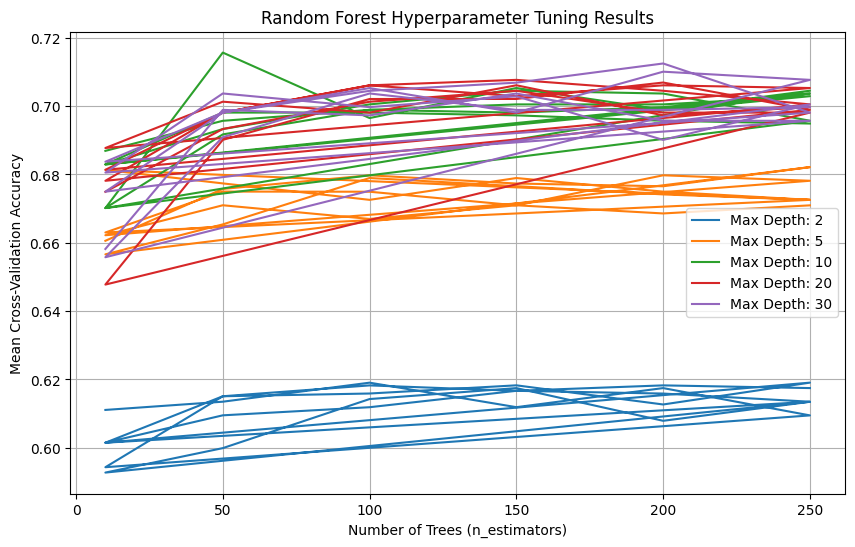

Tuning KNN...
Best Parameters for KNN: {'n_neighbors': 9, 'weights': 'distance'}
Best Cross-Validation Accuracy for KNN: 0.63


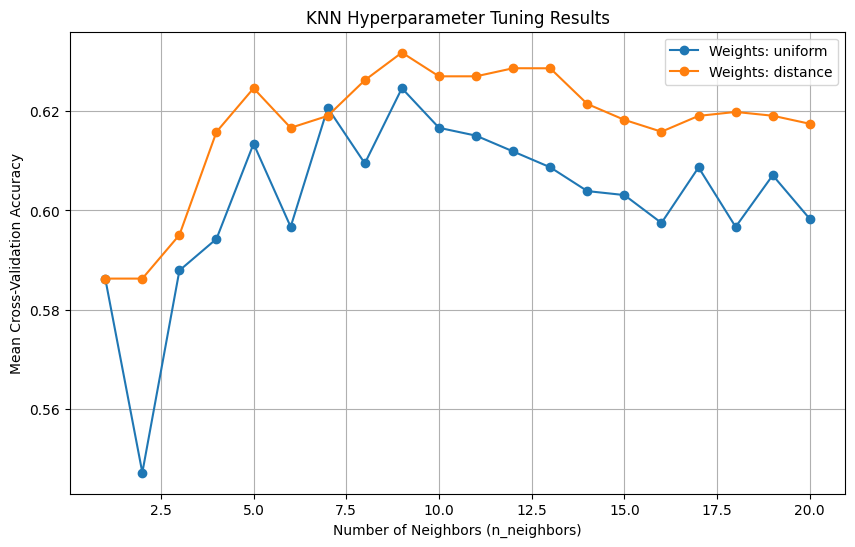

In [25]:
# iterate through the models and perform Grid Search
for model_name, model in models.items():
    print(f'Tuning {model_name}...')
    grid_search = GridSearchCV(model, param_grid[model_name], cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    print(f'Best Parameters for {model_name}: {best_params}')
    print(f'Best Cross-Validation Accuracy for {model_name}: {best_score:.2f}')
    
    results = pd.DataFrame(grid_search.cv_results_)
    
    plt.figure(figsize=(10, 6))
    
    # Logistic Regression, can plot against C and solver
    if model_name == 'Logistic Regression':
        for solver in param_grid[model_name]['solver']:
            subset = results[results['param_solver'] == solver]
            plt.plot(subset['param_C'], subset['mean_test_score'], marker='o', label=f'Solver: {solver}')
        plt.xlabel('Regularization Strength (C)')
            
    # Decision Tree, plot against max_depth and min_samples_split
    elif model_name == 'Decision Tree':
        for min_samples in param_grid[model_name]['min_samples_split']:
            subset = results[results['param_min_samples_split'] == min_samples]
            plt.plot(subset['param_max_depth'], subset['mean_test_score'], label=f'Min Samples Split: {min_samples}')
        plt.xlabel('Max Depth')
    
    #  Random Forest, plot against n_estimators and max_depth
    elif model_name == 'Random Forest':
        for depth in param_grid[model_name]['max_depth']:
            subset = results[results['param_max_depth'] == depth]
            plt.plot(subset['param_n_estimators'], subset['mean_test_score'], label=f'Max Depth: {depth}')
        plt.xlabel('Number of Trees (n_estimators)')
    
    # KNN, can plot against weight type and n_neighbors
    elif model_name == 'KNN':
        for weight in param_grid[model_name]['weights']:
            subset = results[results['param_weights'] == weight]
            plt.plot(subset['param_n_neighbors'], subset['mean_test_score'], marker='o', label=f'Weights: {weight}')
        plt.xlabel('Number of Neighbors (n_neighbors)')

    
    plt.title(f'{model_name} Hyperparameter Tuning Results')
    plt.ylabel('Mean Cross-Validation Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

### 7. Feature Analysis (Without `taxedAssessedValue`)
- Correlation Matrix
- Feature Importances/Coefficients

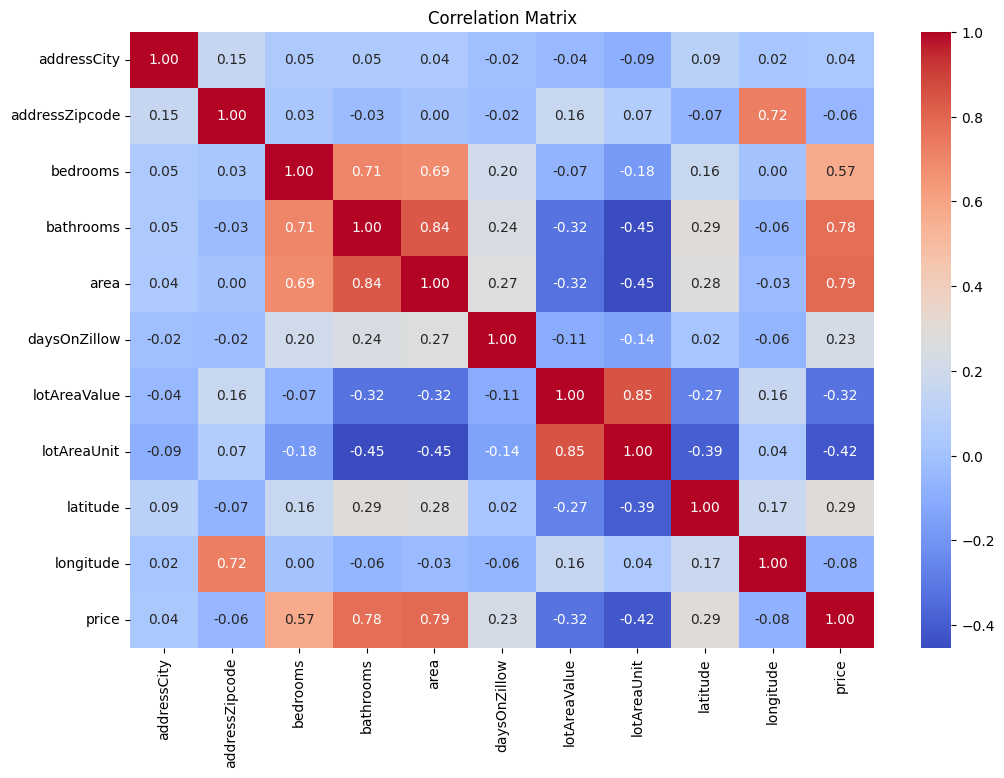

In [26]:
# combine features and label into a single DataFrame
data = features.copy()
data['price'] = df['price']

correlation_matrix = data.corr()

plt.figure(figsize=(12, 8))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

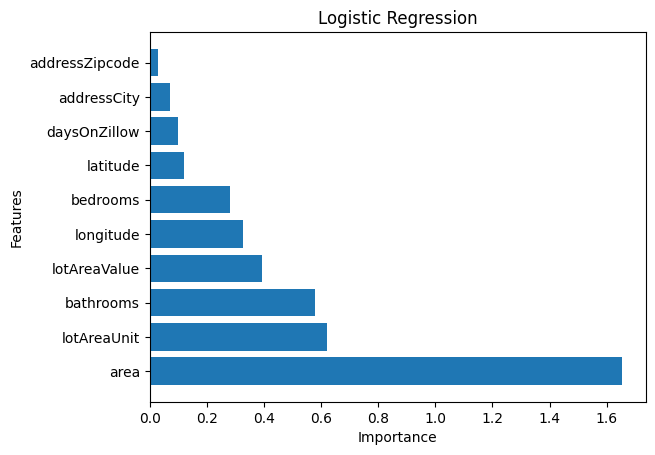

Top 3 Features for Logistic Regression: Index(['area', 'lotAreaUnit', 'bathrooms'], dtype='object')


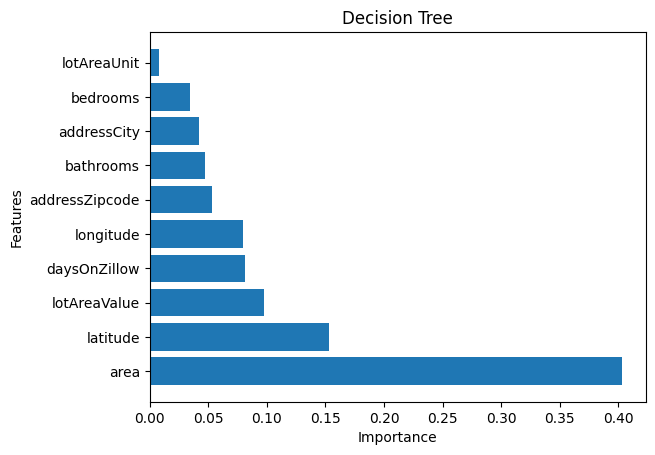

Top 3 Features for Decision Tree: Index(['area', 'latitude', 'lotAreaValue'], dtype='object')


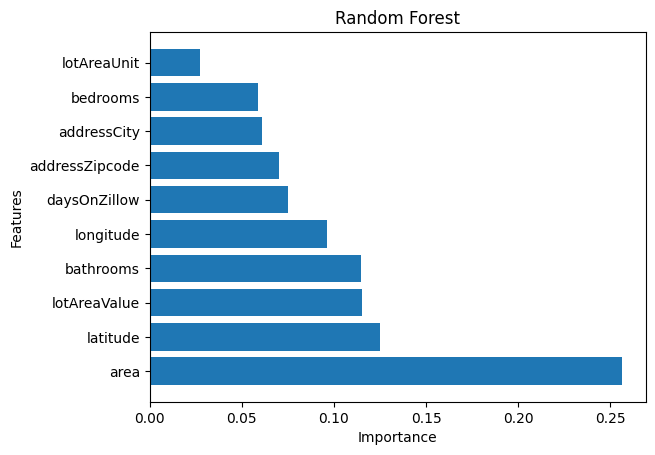

Top 3 Features for Random Forest: Index(['area', 'latitude', 'lotAreaValue'], dtype='object')

KNN does not provide feature importances.


In [27]:
for model_name, model in models.items():
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])  # for Logistic Regression
    else:
        importances = None  # KNN does not have feature importances

    if importances is not None:
        # sort importances and get top 3 features
        sorted_indices = np.argsort(importances)[::-1]
        sorted_importances = importances[sorted_indices]
        top_feature_names = features.columns[sorted_indices]
        
        # Plotting
        plt.barh(top_feature_names, sorted_importances, align='center')
        plt.title(model_name)
        plt.xlabel('Importance')
        plt.ylabel('Features')
        plt.show()
        
        print(f"Top 3 Features for {model_name}: {top_feature_names[:3]}")
    else:
        print(f"\n{model_name} does not provide feature importances.")

### 8. Concluding Thoughts
- Important Observations:
    - There is a high positive correlation between `area` and `bathrooms`/`bedrooms`
    - While removing `taxAssessedValue` did decrease the original base accuracy for the models, the fine-tuned accuracies ended up close to the original fine-tuned models (without `taxAssessedValue`)
    - As noted by the correlation matrix (before and after removing `taxAssessedValue`) there is multicollinearity amongst the features
        - Linear regression will most likely not be adequate for this problem
        - We should explore other regression models
    - The decision tree and random forest models have similar performance, but the random forest slightly out-performs
    - The KNN model barely outperforms the decision tree model upon fine-tuning both
    - Gradient boosting can also be considered as random forest outperforms all current models, both being ensemble methods
- What's Next:
    - While linear regression can be a poor choice, we can also consider other regression models
        - This would utilize the original price label, as binning was only conducted for the sake of using classification models
    - Although this project is comparing the performances between classification and regression models, neural networks with computer vision can also be considered
        - Maybe the images of the listings will impact performance, where the interior and exterior (type of house included, e.g. colonial, ranch, etc.) can provide predictive power